In [85]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch

import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, concatenate,Embedding,Reshape,LSTM,Bidirectional,SpatialDropout1D

from sklearn.model_selection import train_test_split
from sklearn import metrics

RANDOM_STATE=4222

In [86]:
df_train = pd.read_csv('final_datasets/train.csv', encoding='utf-8-sig')
df_test = pd.read_csv('final_datasets/test.csv', encoding='utf-8-sig')
df_valid = pd.read_csv('final_datasets/valid.csv',encoding='utf-8-sig')

In [87]:
df_valid.columns

Index(['Unnamed: 0', 'title', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'country', 'state', 'employment_type_Full-time',
       'employment_type_Not specified', 'employment_type_Other',
       'employment_type_Part-time', 'employment_type_Temporary',
       'industry_common', 'industry_rare', 'industry_uncommon',
       'industry_very rare', 'function_common', 'function_uncommon',
       'country_common', 'country_rare', 'country_uncommon',
       'country_very rare', 'state_common', 'state_rare', 'state_uncommon',
       'state_very rare', 'title_tokens', 'company_profile_tokens',
       'description_tokens', 'requirements_tokens', 'benefits_tokens',
       'spelling_errors_title', 'spelling_errors_company_profile',
       'spelling_errors_description', '

In [88]:
def one_hot_encode_column(df, column_name):

    # Create dummy variables for the column
    dummy_df = pd.get_dummies(df[column_name], prefix=column_name)

    # Join the dummy variables back to the original DataFrame
    df = pd.concat([df, dummy_df], axis=1)

    # Drop the original column
    df.drop(column_name, axis=1, inplace=True)

    return df

df_train.drop(columns=['department','country','state','industry','function'], inplace=True)
df_valid.drop(columns=['department','country','state','industry','function'], inplace=True)
df_test.drop(columns=['department','country','state','industry','function'], inplace=True)

df_train = one_hot_encode_column(df_train, 'employment_type')
df_valid = one_hot_encode_column(df_valid, 'employment_type')
df_test = one_hot_encode_column(df_test, 'employment_type')

In [89]:
df_test

,Unnamed: 0,title,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,company_profile_length,description_length,requirements_length,benefits_length,employment_type_Contract,employment_type_Full-time,employment_type_Not specified,employment_type_Other,employment_type_Part-time,employment_type_Temporary
0,10587,Corporate Travel Counselor On-Site,0,Christopherson Business Travel is the independ...,Full-time Corporate Travel Counselor needed to...,"Proficient GDS skills, Worldspan preferredPref...",Christopherson Business Travel Benefits Portfo...,0,1,1,...,-0.139405,-1.315242,-0.578670,0.584180,0,1,0,0,0,0
1,10611,IT Recruiter,0,PROSULTING IS PEOPLE The ProSulting difference...,Our client a world leader in employment servic...,Qualifications: · Brings a “can do” at...,My client offers all of the advantages you wou...,0,1,1,...,1.341867,-0.021707,-0.479771,0.194013,0,1,0,0,0,0
2,14868,Application Software Engineer,0,"Working at FBNAt FBN, we put farmers first. Fo...",￼FBN's primary mission is to provide farmers w...,"ResponsibilitiesOnce you join our team, you wi...",Health insuranceStock optionsFarm visits!,0,1,0,...,3.219490,-0.707509,0.656781,-0.529732,0,1,0,0,0,0
3,15868,Release Manager,0,"ForeFront (Fair Haven, NJ) is a fast-growing b...",RESPONSIBILITIES:The Release Manager will work...,REQUIREMENTS:Extremely detail oriented persona...,"WHY FOREFRONT?Talented, innovative, diverse, a...",0,1,0,...,0.317404,0.476731,0.402469,0.762882,0,1,0,0,0,0
4,10230,Communications Manager,0,#URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389...,Qualified candidates are encouraged to apply d...,Some of the desired skills and experience for ...,Our core values drive our culture. This is wha...,0,1,0,...,0.251906,1.572092,0.138739,5.117263,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,3896,Web Developer,0,Cashie Commerce is the fastest way to create a...,The Cashie Commerce team is looking for a tale...,"To perform this job successfully, an individua...",Cashie Commerce offers a competitive salary an...,0,1,1,...,0.520617,-0.546568,-0.079466,0.223797,0,1,0,0,0,0
2678,12171,Inside Sales Professional-Flint,0,"ABC Supply Co., Inc. is the nation’s largest w...",If you are an experienced retail service profe...,"As a Sales Representative, you must have the a...","As a Sales Representative, you may have opport...",0,1,0,...,0.100756,0.877883,0.485670,1.242400,0,1,0,0,0,0
2679,10600,Creative Director,0,hello worldtalents23_ drives the change in dig...,We are the most efficient and motivating way t...,Strong communication and leadership skillsHand...,High impact and responsibility in a very succe...,0,1,1,...,-0.853171,0.232917,0.160717,0.488872,0,1,0,0,0,0
2680,14327,Project Manager Marketing DACH,0,Babbel enables anyone to learn languages in an...,"Negotiate, close and launch new media cooperat...",University degree (min. Bachelor’s degree or c...,Significant budget to manage and high degree o...,0,1,0,...,0.015104,-0.898476,-0.351046,0.262515,0,0,1,0,0,0


In [90]:
# df_valid, df_test = train_test_split(df_test, test_size=0.5, random_state=4222, stratify=df_test['fraudulent'])

In [91]:
import gensim.downloader as api
import numpy as np

model = api.load("word2vec-google-news-300")

def get_sentence_vectors(sentence):
    tokens = sentence.split()
    vectors = [model[word] for word in tokens if word in model]
    
    if not vectors:
        return np.zeros(100)
    
    sentence_vector = np.mean(vectors, axis=0)[:100]
    return sentence_vector

In [92]:
def preprocess(df):
    cols_to_drop = ['Unnamed: 0','title_tokens', 'company_profile_tokens',
                'description_tokens', 'requirements_tokens', 'benefits_tokens']
    df.drop(columns=cols_to_drop, inplace=True)
    
    text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
    
    for col in text_cols:
        df[col] = df[col].apply(lambda x:get_sentence_vectors(x))
    
    return df

In [93]:
df_test = preprocess(df_test)
df_train = preprocess(df_train)
df_valid = preprocess(df_valid)

In [94]:
embeddings = ['title', 'company_profile', 'description', 'requirements', 'benefits']

In [95]:
y_train = df_train['fraudulent'].values
y_valid = df_valid['fraudulent'].values
y_test = df_test['fraudulent'].values

In [96]:
def convert_to_tensors(X_train_values):
    tensors = torch.from_numpy(np.vstack(X_train_values))
    return tf.constant(tensors.numpy(), dtype=tf.float32)

In [97]:
def get_tensors(df_col):
    return convert_to_tensors(df_col.values)

In [98]:
X_train_title = get_tensors(df_train['title'])
X_train_company_profile = get_tensors(df_train['company_profile'])
X_train_description = get_tensors(df_train['description'])
X_train_requirements = get_tensors(df_train['requirements'])
X_train_benefits = get_tensors(df_train['benefits'])

X_valid_title = get_tensors(df_valid['title'])
X_valid_company_profile = get_tensors(df_valid['company_profile'])
X_valid_description = get_tensors(df_valid['description'])
X_valid_requirements = get_tensors(df_valid['requirements'])
X_valid_benefits = get_tensors(df_valid['benefits'])

X_test_title = get_tensors(df_test['title'])
X_test_company_profile = get_tensors(df_test['company_profile'])
X_test_description = get_tensors(df_test['description'])
X_test_requirements = get_tensors(df_test['requirements'])
X_test_benefits = get_tensors(df_test['benefits'])

In [99]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE)

X_train_title,y_train_resampled = smote.fit_resample(X_train_title,y_train)

X_train_company_profile,_ = smote.fit_resample(X_train_company_profile,y_train)

X_train_description,_ = smote.fit_resample(X_train_description,y_train)

X_train_requirements,_ = smote.fit_resample(X_train_requirements,y_train)

X_train_benefits,_ = smote.fit_resample(X_train_benefits,y_train)

In [100]:
def reshape_x(X_values):
    X_values = np.array(X_values)
    return X_values.reshape(X_values.shape[0], 1, X_values.shape[1])

def reshape_y(y_values):
    y_values = np.array(y_values)
    return y_values.reshape(y_values.shape[0], 1, 1)

In [101]:
X_train_title = reshape_x(X_train_title)
X_train_company_profile = reshape_x(X_train_company_profile)
X_train_description = reshape_x(X_train_description)
X_train_requirements = reshape_x(X_train_requirements)
X_train_benefits = reshape_x(X_train_benefits)

X_valid_title = reshape_x(X_valid_title)
X_valid_company_profile = reshape_x(X_valid_company_profile)
X_valid_description = reshape_x(X_valid_description)
X_valid_requirements = reshape_x(X_valid_requirements)
X_valid_benefits = reshape_x(X_valid_benefits)

X_test_title = reshape_x(X_test_title)
X_test_company_profile = reshape_x(X_test_company_profile)
X_test_description = reshape_x(X_test_description)
X_test_requirements = reshape_x(X_test_requirements)
X_test_benefits = reshape_x(X_test_benefits)

y_train_resampled = reshape_y(y_train_resampled)
y_valid = reshape_y(y_valid)
y_test = reshape_y(y_test)

In [102]:
embeddings.append('fraudulent')
X_train_non_text = df_train.drop(columns=embeddings).values
X_valid_non_text = df_valid.drop(columns=embeddings).values
X_test_non_text = df_test.drop(columns=embeddings).values

In [103]:
X_train_non_text

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [104]:
X_train_non_text, _ = smote.fit_resample(X_train_non_text,y_train)

In [105]:
def create_neural_net(input_shape):
    model = Sequential([
        Dense(input_shape, activation='relu', input_shape=(input_shape,)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [106]:
def create_lstm(input_shape):
    model = Sequential([
#         Embedding(len(embedding), output_dim=50, weights=[embedding], input_length=len(embedding), trainable=False),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(64, input_shape=(1, 100))),
#        LSTM(64, input_shape=(1, 100)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [107]:
model_title = create_lstm(100)
model_company_profile = create_lstm(100)
model_description = create_lstm(100)
model_requirements = create_lstm(100)
model_benefits = create_lstm(100)
model_non_text = create_neural_net(X_train_non_text.shape[1])

In [108]:
model_non_text.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 46)                2162      
                                                                 
 dense_6 (Dense)             (None, 1)                 47        
                                                                 
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________


In [109]:
model_title.fit(X_train_title, y_train_resampled, validation_data=(X_valid_title, y_valid), epochs=10, verbose=2)
model_company_profile.fit(X_train_company_profile, y_train_resampled, validation_data=(X_valid_company_profile, y_valid), epochs=10, verbose=2)
model_description.fit(X_train_description, y_train_resampled, validation_data=(X_valid_description, y_valid), epochs=10, verbose=2)
model_requirements.fit(X_train_requirements, y_train_resampled, validation_data=(X_valid_requirements, y_valid), epochs=10, verbose=2)
model_benefits.fit(X_train_benefits, y_train_resampled, validation_data=(X_valid_benefits, y_valid), epochs=10, verbose=2)

Epoch 1/10
745/745 - 6s - loss: 0.5428 - accuracy: 0.7288 - val_loss: 0.4483 - val_accuracy: 0.7916 - 6s/epoch - 9ms/step
Epoch 2/10
745/745 - 2s - loss: 0.4876 - accuracy: 0.7650 - val_loss: 0.5268 - val_accuracy: 0.7282 - 2s/epoch - 3ms/step
Epoch 3/10
745/745 - 2s - loss: 0.4450 - accuracy: 0.7947 - val_loss: 0.4423 - val_accuracy: 0.7908 - 2s/epoch - 2ms/step
Epoch 4/10
745/745 - 2s - loss: 0.4087 - accuracy: 0.8162 - val_loss: 0.3748 - val_accuracy: 0.8367 - 2s/epoch - 3ms/step
Epoch 5/10
745/745 - 2s - loss: 0.3756 - accuracy: 0.8360 - val_loss: 0.4128 - val_accuracy: 0.8151 - 2s/epoch - 3ms/step
Epoch 6/10
745/745 - 2s - loss: 0.3485 - accuracy: 0.8524 - val_loss: 0.3999 - val_accuracy: 0.8221 - 2s/epoch - 3ms/step
Epoch 7/10
745/745 - 2s - loss: 0.3249 - accuracy: 0.8652 - val_loss: 0.3362 - val_accuracy: 0.8684 - 2s/epoch - 3ms/step
Epoch 8/10
745/745 - 2s - loss: 0.3100 - accuracy: 0.8743 - val_loss: 0.3780 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 9/10
745/745 - 2s 

In [110]:
concatenated = concatenate([model_title.output, 
                            model_company_profile.output, 
                            model_description.output, 
                            model_requirements.output, 
                            model_benefits.output,
                            model_non_text.output])


dense = Dense(32, activation='relu')(concatenated)
outputs = Dense(1, activation='sigmoid')(dense)

final_model = Model(inputs=[model_title.input, 
                    model_company_profile.input, 
                    model_description.input, 
                    model_requirements.input, 
                    model_benefits.input,
                    model_non_text.input], outputs=outputs)

In [111]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [112]:
final_model.fit([X_train_title,
                X_train_company_profile,
                X_train_description,
                X_train_requirements,
                X_train_benefits,
                X_train_non_text], y_train_resampled, epochs=10, batch_size=32,
                validation_data=([X_valid_title,
                                    X_valid_company_profile,
                                    X_valid_description,
                                    X_valid_requirements,
                                    X_valid_benefits,
                                    X_valid_non_text], y_valid))

Epoch 1/10
745/745 [==============================] - 21s 11ms/step - loss: 0.2268 - accuracy: 0.9307 - val_loss: 0.1102 - val_accuracy: 0.9601
Epoch 2/10
745/745 [==============================] - 5s 6ms/step - loss: 0.0899 - accuracy: 0.9692 - val_loss: 0.0954 - val_accuracy: 0.9638
Epoch 3/10
745/745 [==============================] - 4s 6ms/step - loss: 0.0710 - accuracy: 0.9743 - val_loss: 0.0692 - val_accuracy: 0.9754
Epoch 4/10
745/745 [==============================] - 4s 5ms/step - loss: 0.0544 - accuracy: 0.9819 - val_loss: 0.0758 - val_accuracy: 0.9732
Epoch 5/10
745/745 [==============================] - 4s 6ms/step - loss: 0.0472 - accuracy: 0.9835 - val_loss: 0.0618 - val_accuracy: 0.9817
Epoch 6/10
745/745 [==============================] - 4s 6ms/step - loss: 0.0398 - accuracy: 0.9863 - val_loss: 0.0646 - val_accuracy: 0.9806
Epoch 7/10
745/745 [==============================] - 4s 6ms/step - loss: 0.0359 - accuracy: 0.9883 - val_loss: 0.0657 - val_accuracy: 0.9795
Epoc

In [113]:
def get_confusion_matrix(actual, predicted, title):
    cf = metrics.confusion_matrix(actual, predicted)
    group_names = ['True Negative','False Positive','False Negative','True Positive'] 
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()] 

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    s = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', xticklabels=['non fraud', 'fraud'], yticklabels=['non fraud', 'fraud'])
    s.set(xlabel='Predictions', ylabel='True Labels', title=title)
    return s

745/745 [==============================] - 2s 2ms/step


<AxesSubplot:xlabel='Predictions', ylabel='True Labels'>

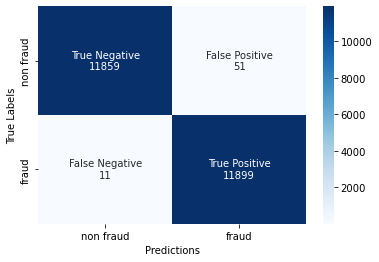

In [115]:
y_pred = final_model.predict([X_train_title,
                X_train_company_profile,
                X_train_description,
                X_train_requirements,
                X_train_benefits,
                X_train_non_text])

final_output = []
for x in y_pred:
    if x<=0.5:
        final_output.append([0])
    else:
        final_output.append([1])
get_confusion_matrix(y_train_resampled.reshape(23820), final_output, "")

In [116]:
# def dwnsmple(df,df2):
#     newdf = np.concatenate((df[:9066],df2[:100]),axis=0)
#     return newdf

In [117]:
# X_test_title = dwnsmple(X_train_title,X_test_title)
# X_test_company_profile = dwnsmple(X_train_company_profile,X_test_company_profile)
# X_test_description = dwnsmple(X_train_description,X_test_description)
# X_test_requirements = dwnsmple(X_train_requirements,X_test_requirements)
# X_test_benefits = dwnsmple(X_train_benefits,X_test_benefits)
# y_test_resampled = dwnsmple(y_train_resampled,y_test)
# X_test_non_text = dwnsmple(X_train_non_text,X_test_non_text)

In [118]:
X_train_benefits.shape

(23820, 1, 100)

In [119]:
# y_pred = final_model.predict([X_train_title,
#                 X_train_company_profile,
#                 X_train_description,
#                 X_train_requirements,
#                 X_train_benefits,
#                 X_train_non_text])

# final_output = []
# for x in y_pred:
#     if x<=0.5:
#         final_output.append([0])
#     else:
#         final_output.append([1])
# get_confusion_matrix(y_test.reshape(4583), final_output, "")

84/84 [==============================] - 0s 3ms/step


<AxesSubplot:xlabel='Predictions', ylabel='True Labels'>

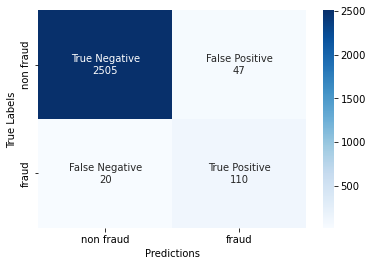

In [122]:
y_pred = final_model.predict([X_test_title,
                X_test_company_profile,
                X_test_description,
                X_test_requirements,
                X_test_benefits,
                X_test_non_text])

final_output = []
for x in y_pred:
    if x<=0.5:
        final_output.append([0])
    else:
        final_output.append([1])
get_confusion_matrix(y_test.reshape(2682), final_output, "")

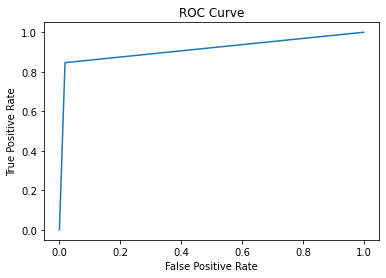

Accuracy: 0.975
Precision: 0.701
Recall: 0.846
AUC-ROC: 0.914
f1: 0.767


In [132]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,f1_score
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test.reshape(2682), final_output)
precision = precision_score(y_test.reshape(2682), final_output)
recall = recall_score(y_test.reshape(2682), final_output)
auc_roc = roc_auc_score(y_test.reshape(2682), final_output)
f1 = f1_score(y_test.reshape(2682), final_output)

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test.reshape(2682), final_output)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# print the results
print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('AUC-ROC: {:.3f}'.format(auc_roc))
print('f1: {:.3f}'.format(f1))

In [125]:
y_test.shape

(2682, 1, 1)

In [127]:
y_test.reshape(2682)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

84/84 [==============================] - 0s 3ms/step


<AxesSubplot:xlabel='Predictions', ylabel='True Labels'>

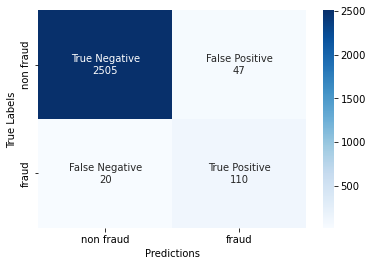

In [129]:
y_pred = final_model.predict([X_test_title,
                X_test_company_profile,
                X_test_description,
                X_test_requirements,
                X_test_benefits,
                X_test_non_text])

final_output = []
for x in y_pred:
    if x<=0.5:
        final_output.append([0])
    else:
        final_output.append([1])
get_confusion_matrix(y_test.reshape(2682), final_output, "")        

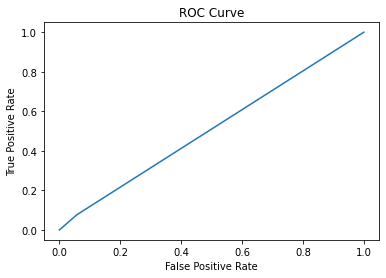

Accuracy: 0.900
Precision: 0.064
Recall: 0.077
AUC-ROC: 0.510


In [130]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_valid.reshape(2682), final_output)
precision = precision_score(y_valid.reshape(2682), final_output)
recall = recall_score(y_valid.reshape(2682), final_output)
auc_roc = roc_auc_score(y_valid.reshape(2682), final_output)

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid.reshape(2682), final_output)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# print the results
print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('AUC-ROC: {:.3f}'.format(auc_roc))